# Self-Driving Car Engineer Nanodegree


## Project: **Advanced Lane Finding** 

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import pickle
import glob

from helper_functions import undistortImage, warpImage, unwarpImage, absSobelThresh, getColorFilter, gaussianBlur

%matplotlib inline

In [2]:
# HSV range for yellow and white lane lines
yellow_low = np.array([0, 100, 100])
yellow_high = np.array([50, 255, 255])    
white_low = np.array([20, 0, 180])
white_high = np.array([255, 80, 255])

first_frame = True

In [3]:
# Load saved parameters
camera_params = pickle.load(open("camera_params.pkl", "rb"))
camera_mtx = camera_params[0]
camera_dist = camera_params[1]

transform_matrix = pickle.load(open("transform_matrix.pkl", "rb"))
M = transform_matrix[0]
Minv = transform_matrix[1]

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


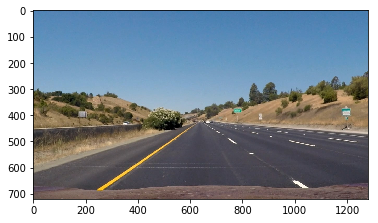

In [4]:
#reading in an image
image = mpimg.imread('test_images/straight_lines1.jpg')
img_size = (image.shape[1], image.shape[0])

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

In [5]:
def laneSelectionFilter(image):
    # Convert image to HSV to extract lane lines based on yellow and white color
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        
    # Get yellow and white filters
    yellow_filter = getColorFilter(hsv, yellow_low, yellow_high)
    white_filter = getColorFilter(hsv, white_low, white_high)
    
    lane_color_filter = cv2.bitwise_or(yellow_filter, white_filter)
    #plt.imshow(lane_color_filter)
    # The lane filters work well for dark road images but fails when the road is very bright
    
    # Convert image to HLS 
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

    # Apply sobel filter on L channel
    l_channel = hls[:,:,1]
    l_channel_x = absSobelThresh(l_channel, 'x', 5, (50,225))
    l_channel_y = absSobelThresh(l_channel, 'y', 5, (50,225))
    l_channel_filter = np.copy(cv2.bitwise_or(l_channel_x, l_channel_y))
    
    # Apply sobel filter on S channel
    s_channel = hls[:,:,2]
    s_channel_x = absSobelThresh(s_channel, 'x', 5, (50,225))
    s_channel_y = absSobelThresh(s_channel, 'y', 5, (50,225))
    s_channel_filter = np.copy(cv2.bitwise_or(s_channel_x, s_channel_y))
    
    # Combine l and 
    ls_channel_filter = cv2.bitwise_or(l_channel_filter, s_channel_filter)
    ls_channel_filter = gaussianBlur(ls_channel_filter,25)
    
    # Apply Sobel and Color filter
    lane_filter = np.zeros_like(ls_channel_filter)
    lane_filter[(lane_color_filter >= 0.5) | (ls_channel_filter >= 0.5)] = 1
    
    return lane_color_filter    

## Build Advanced Lane Finding Pipeline



In [6]:
def pipeline(image):
    global first_frame

    # Undistort the image
    undist = undistortImage(image, camera_mtx, camera_dist)
    
    # Perform perspective transform to get bird's eye view of the lanes
    warped = warpImage(undist, M, img_size)
    
    # Detect lane lines using filtering and thresholding techniques
    lane_filter = laneSelectionFilter(warped)
        
    # Find lane pixel positions
    if True == Left_Lane.first_frame:
        Left_Lane.findLane(lane_filter)
    else:
        Left_Lane.estimateLane(lane_filter)
        if Left_Lane.not_detected_age > 2:
            Left_Lane.findLane(lane_filter)  
        
    if True == Right_Lane.first_frame:
        Right_Lane.findLane(lane_filter)
    else:
        Right_Lane.estimateLane(lane_filter)
        if Right_Lane.not_detected_age > 2:
            Right_Lane.findLane(lane_filter)    
        
    # Fit a second order polynomial to each
    Left_Lane.current_fit = np.polyfit(Left_Lane.ally, Left_Lane.allx, 2)
    Right_Lane.current_fit = np.polyfit(Right_Lane.ally, Right_Lane.allx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, lane_filter.shape[0]-1, lane_filter.shape[0] )
    left_fitx = Left_Lane.current_fit[0]*ploty**2 + Left_Lane.current_fit[1]*ploty + Left_Lane.current_fit[2]
    right_fitx = Right_Lane.current_fit[0]*ploty**2 + Right_Lane.current_fit[1]*ploty + Right_Lane.current_fit[2]
    
    # Compute radius of curvature
    Left_Lane.findRadiusOfCurvature(ploty, left_fitx)
    Right_Lane.findRadiusOfCurvature(ploty, right_fitx)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(lane_filter).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    final_image = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    # Print radius of curvature on video
    if 0:
        cv2.putText(final_image, 'Radius of Curvature Left:{}(m),'.format(int(Left_Lane.radius_of_curvature)), (120,140),
                 fontFace = 16, fontScale = 1.5, color=(255,255,255), thickness = 2)
        cv2.putText(final_image, 'Right:{}(m)'.format(int(Right_Lane.radius_of_curvature)), (588,190),
                 fontFace = 16, fontScale = 1.5, color=(255,255,255), thickness = 2)
    else:
        cv2.putText(final_image, 'Not Detected Left:{}(m),'.format(int(Left_Lane.not_detected_age)), (120,140),
                 fontFace = 16, fontScale = 1.5, color=(255,255,255), thickness = 2)
        cv2.putText(final_image, 'Right:{}(m)'.format(int(Right_Lane.not_detected_age)), (400,190),
                 fontFace = 16, fontScale = 1.5, color=(255,255,255), thickness = 2)
    
    plt.imshow(final_image)    
    
    return final_image

In [12]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        self.first_frame = True
        # was the line detected in the last iteration?
        self.detected = False  
        # number of consecutive iterations for which the lane was not detected
        self.not_detected_age = 0  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
    
    def findLane(self, binary_warped):
        self.first_frame = False
        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        #plt.imshow(out_img)
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        #print(midpoint)
        if self == Left_Lane:
            x_base = np.argmax(histogram[:midpoint])
        elif self == Right_Lane:
            x_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        x_current = x_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_x_low = x_current - margin
            win_x_high = x_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_x_low,win_y_low),(win_x_high,win_y_high),
            (0,255,0), 2)
            # Identify the nonzero pixels in x and y within the window
            good_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_x_low) &  (nonzerox < win_x_high)).nonzero()[0]
            # Append these indices to the lists
            lane_inds.append(good_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_inds) > minpix:
                x_current = np.int(np.mean(nonzerox[good_inds]))

        # Concatenate the arrays of indices
        lane_inds = np.concatenate(lane_inds)

        # Extract left and right line pixel positions
        self.allx = nonzerox[lane_inds]
        self.ally = nonzeroy[lane_inds]
        
        self.not_detected_age = 0
        
    def estimateLane(self, binary_warped):
        # Assume you now have a new warped binary image 
        # from the next frame of video (also called "binary_warped")
        # It's now much easier to find line pixels!
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 25
        lane_inds = ((nonzerox > (self.current_fit[0]*(nonzeroy**2) + self.current_fit[1]*nonzeroy + self.current_fit[2] - margin)) & 
                     (nonzerox < (self.current_fit[0]*(nonzeroy**2) + self.current_fit[1]*nonzeroy + self.current_fit[2] + margin))) 
    
        if np.sum(lane_inds) > 10:
            # Again, extract left and right line pixel positions
            self.allx = nonzerox[lane_inds]
            self.ally = nonzeroy[lane_inds]
        else:
            self.not_detected_age += 1
            
    
    def findRadiusOfCurvature(self, ploty, fitx):
        # Define y-value where we want radius of curvature
        # I'll choose the maximum y-value, corresponding to the bottom of the image
        y_eval = np.max(ploty)
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension

        # Fit new polynomials to x,y in world space
        fit_cr = np.polyfit(ploty*ym_per_pix, fitx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        self.radius_of_curvature = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])


In [13]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    result = pipeline(image)

    return result

## Test pipeline on an image


array([[[ 97, 153, 200],
        [ 97, 153, 200],
        [ 97, 153, 200],
        ..., 
        [ 88, 150, 197],
        [ 87, 149, 196],
        [ 85, 147, 194]],

       [[ 98, 154, 201],
        [ 97, 153, 200],
        [ 97, 153, 200],
        ..., 
        [ 87, 149, 196],
        [ 86, 148, 195],
        [ 85, 147, 194]],

       [[ 98, 154, 201],
        [ 98, 154, 201],
        [ 98, 154, 201],
        ..., 
        [ 87, 149, 196],
        [ 86, 148, 195],
        [ 86, 148, 195]],

       ..., 
       [[103,  89, 104],
        [104,  90, 104],
        [105,  91, 105],
        ..., 
        [126, 107, 100],
        [127, 108, 101],
        [123, 104,  97]],

       [[105,  91, 103],
        [106,  92, 104],
        [107,  92, 105],
        ..., 
        [125, 106,  99],
        [125, 106,  99],
        [123, 104,  97]],

       [[110,  94, 105],
        [110,  94, 105],
        [110,  94, 104],
        ..., 
        [126, 107, 100],
        [126, 107, 100],
        [125, 107,

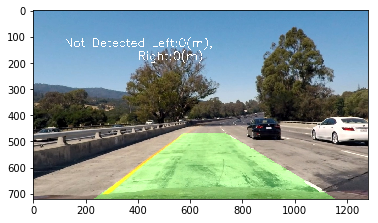

In [9]:
Left_Lane = Line()
Right_Lane = Line()
image = mpimg.imread('test_images/test1.jpg')
process_image(image)

## Test pipeline on video

In [10]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 100/101 [00:24<00:00,  3.87it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 26.9 s


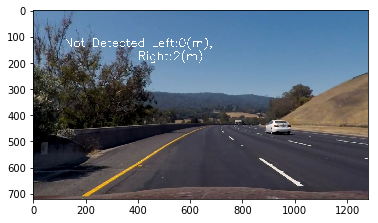

In [14]:
video_output = 'project_video_output.mp4'

Left_Lane = Line()
Right_Lane = Line()
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("project_video.mp4").subclip(0,1)
clip1 = VideoFileClip("project_video.mp4").subclip(21,25)
video_frame = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time video_frame.write_videofile(video_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.
